[View in Colaboratory](https://colab.research.google.com/github/avs20/HOG_Playground/blob/master/HOG_Digits.ipynb)

In [0]:
#install opencv 
# !apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# import cv2

In [0]:
# from google.colab import files

# uploaded = files.upload()

In [0]:
### TRAIN DIGITS
import cv2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



SZ = 20
CLASS_N = 10

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img




def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0


def get_hog() : 
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR


    


## LOADING AND SEEING THE DATA

Loading digits from digits.png ... 


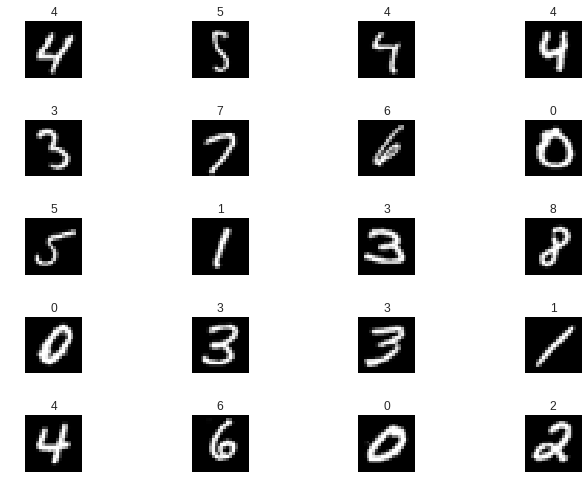

In [4]:

print('Loading digits from digits.png ... ')
# Load data.
digits, labels = load_digits('digits.png')
# print(digits[0])


plt.figure(figsize=(5,5))

import random 


f = plt.figure(figsize=(10,7))

for i in range(20):

  
  index = random.randint(0,digits.shape[0])
  plt.subplot( 5, 4, i+1 )
  plt.axis('off')
  plt.title(labels[index])

  plt.imshow(digits[index], cmap="gray")
  
  
plt.tight_layout( w_pad=0.5, h_pad=1.0)

plt.show()
  



## Aligin images to veritical before training 

Deskew images ... 


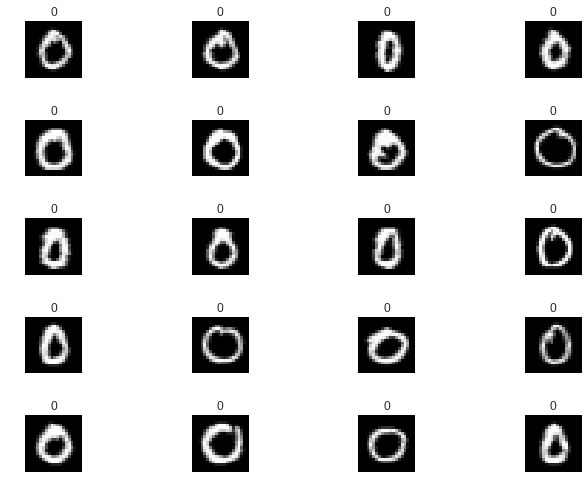

In [5]:
print('Deskew images ... ')
digits_deskewed = list(map(deskew, digits))

f = plt.figure(figsize=(10,7))

for i in range(20):


  plt.subplot( 5, 4, i+1 )
  plt.axis('off')

  plt.imshow(digits_deskewed[i], cmap="gray")
  plt.title(labels[i])

plt.tight_layout( w_pad=0.5, h_pad=1.0)

plt.show()

## Calculating HOG Descriptor



In [6]:
print('Defining HoG parameters ...')
# HoG feature descriptor
hog = get_hog();

print('Calculating HoG descriptor for every image ... ')
hog_descriptors = []
for img in digits_deskewed:
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)

Defining HoG parameters ...
Calculating HoG descriptor for every image ... 


## Splitting the data into training and test set 

In [7]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hog_descriptors, labels, test_size = 0.3, random_state = 10)
print("Training size", X_train.shape[0])
print("Testing Size" , X_test.shape[0])

Training size 3500
Testing Size 1500


## Training the model 


In [8]:
from sklearn.svm import SVC

model = SVC(kernel = "rbf", C = 50, gamma =0.50625)

model.fit(X_train, y_train)
preds = model.predict(X_test)


from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, preds, labels = np.arange(0,10))
print("Confusion matrix")
print(mat)

print("Accuracy:" , model.score(X_test, y_test))

Confusion matrix
[[150   0   0   0   0   0   1   0   0   0]
 [  0 142   1   0   0   0   0   1   0   0]
 [  0   1 164   0   0   0   0   0   1   0]
 [  0   0   1 148   0   0   0   1   1   0]
 [  0   0   0   0 147   0   1   0   0   3]
 [  0   0   0   1   0 142   0   1   1   0]
 [  0   0   1   0   0   0 128   0   0   0]
 [  0   4   0   1   0   0   0 148   1   3]
 [  0   0   0   0   0   0   0   0 160   1]
 [  1   0   0   0   1   0   0   2   1 140]]
Accuracy: 0.9793333333333333


We got an accuracy of 97.9% on a simple SVM algorithm with a simple dataset. 
This tells that the HOG descriptors work very well for different shapes and sizes. 

This is easier to code and work with. 

## References :

1. https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/